<a href="https://colab.research.google.com/github/AndriyBabiy/goit_mlf_final_project/blob/main/MLF_Final_Project_Andriy_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Foundations - Final Project
**Overview of the Project**

**Dataset** - Set of anonymised data from a telecommunications company. Project lies in creating a prediction model that can work with a large amount of input features.

**Goal** - Find the customers that are likely to switch their service provider (Predicting Customer Churn)

*This code was build out using the Spyder IDE and as such a lot of the information is saved in variables that were accessible in the variable exporer section of the interface. I have added print versions of the results in order to have the logical process be more evident in the notebook format.*

*There is also a lot of code commented out as during the process of the project I encountered difficulties in effectively applying the sklearn.Pipeline approach to building out the model processing and have left in the comments for anyone interested*

## Admin

### Code exported from Kaggle

In [76]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ml-fundamentals-and-applications-2024-08:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F83793%2F9336896%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240826%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240826T212952Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4e669f4d499434babd39cf3fb1db8fc8e280bc1a11ea83c3577c8768c6c5bb5f4a373424fcee4bb89fb950a1ddc107a609176654ad6ff5044fd0e6124fb472c4422d8ec247d3cecccdb147a40aaaf91128b1b183830a55b334e0093047c6dc105bcb19931562133226cbe40d07ae36961fd186da424c8725b2d18dcfb06da8d056611f368e28f5f339798fb889423d952fcc37f873ce65a6c77c56c29e069817f7960a3103948941c6b9a3cb3385e5246cf655ffab8358cfa910bc1291f1ab7e9b133d4bb330b0dae1420f4e88fdd08ac358a15131623b3f4d6102263d840dc2ea796ef39c17380e8b1fcc716ae66d6f8f673e9ffeb602765ee8db5818dbc099'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2270542 bytes downloaded
Downloaded and uncompressed: ml-fundamentals-and-applications-2024-08
Data source import complete.


### Library Imports

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
!pip install category_encoders
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from xgboost import XGBClassifier
import lightgbm as lgb

## Data Import

In [78]:
# Import data - Spyder
# data_loc = './data/final_proj_data.csv'
# valid_loc = './data/final_proj_test 2.csv'

# Import data - Kaggle
data_loc = '/kaggle/input/ml-fundamentals-and-applications-2024-08/final_proj_data.csv'
valid_loc = '/kaggle/input/ml-fundamentals-and-applications-2024-08/final_proj_test.csv'

data_full = pd.read_csv(data_loc)
valid = pd.read_csv(valid_loc)

X_data = data_full.copy()
y_target = X_data.pop('y')

## Exploratory Data Analysis

### Initial analysis of the data
In this Section I started off by getting an inital overview of the data that I am dealing with, seeing the datatypes that are available and the proportions of null values

In [79]:
# Initial view of the data
X_data.info()
X_descr = X_data.describe()
X_null = (X_data.isnull().sum()/10000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 230 entries, Var1 to Var230
dtypes: float64(191), int64(1), object(38)
memory usage: 17.5+ MB


## Processing the data

### Splitting the data into training and testing datasets

In [80]:
# Train-Test split

# =============================================================================
# X_data, X_test, y_target, y_test = (
#     train_test_split(X_data,
#                      y_target,
#                      test_size=0.2,
#                      random_state=42))
#
# X_data_concat = pd.concat([X_data, y_target], axis=1)
# X_test_data_concat = pd.concat([X_test, y_test], axis=1)
#
# X_data_concat = X_data_concat.reset_index().drop(columns='index')
# y_target = X_data_concat.pop('y')
# X_data = X_data_concat
#
# X_test_data_concat = X_test_data_concat.reset_index().drop(columns='index')
# y_test = X_test_data_concat.pop('y')
# X_test = X_test_data_concat
# =============================================================================

### Removing the Colums that had over 35% of the values missing

This decision was made as according to best practices, it is best to not try impute data when there are more than 30% of the values missing as it will bring in unnecessary noise into the dataset.

In [81]:
print(X_null.sort_values(ascending=False))

Var230    1.0
Var175    1.0
Var55     1.0
Var39     1.0
Var141    1.0
         ... 
Var202    0.0
Var199    0.0
Var198    0.0
Var196    0.0
Var212    0.0
Length: 230, dtype: float64


In [82]:
# Removign columns that have more than 35% of the values missing
null_cols = X_data.columns[X_data.isna().mean().gt(0.35)]

X_data = X_data.drop(columns = null_cols)
# X_test = X_test.drop(columns = null_cols)
valid = valid.drop(columns = null_cols)

### Splitting the data into the different datatypes

In [83]:
# Split data into numerical and categorical groups
X_num = X_data.select_dtypes(include=np.number)
X_cat = X_data.select_dtypes(include='object')


# X_test_num = X_test.select_dtypes(include=np.number)
# X_test_cat = X_test.select_dtypes(include='object')


valid_num = valid.select_dtypes(include=np.number)
valid_cat = valid.select_dtypes(include='object')

#### Taking an initial look at the Numerical Data Distributions

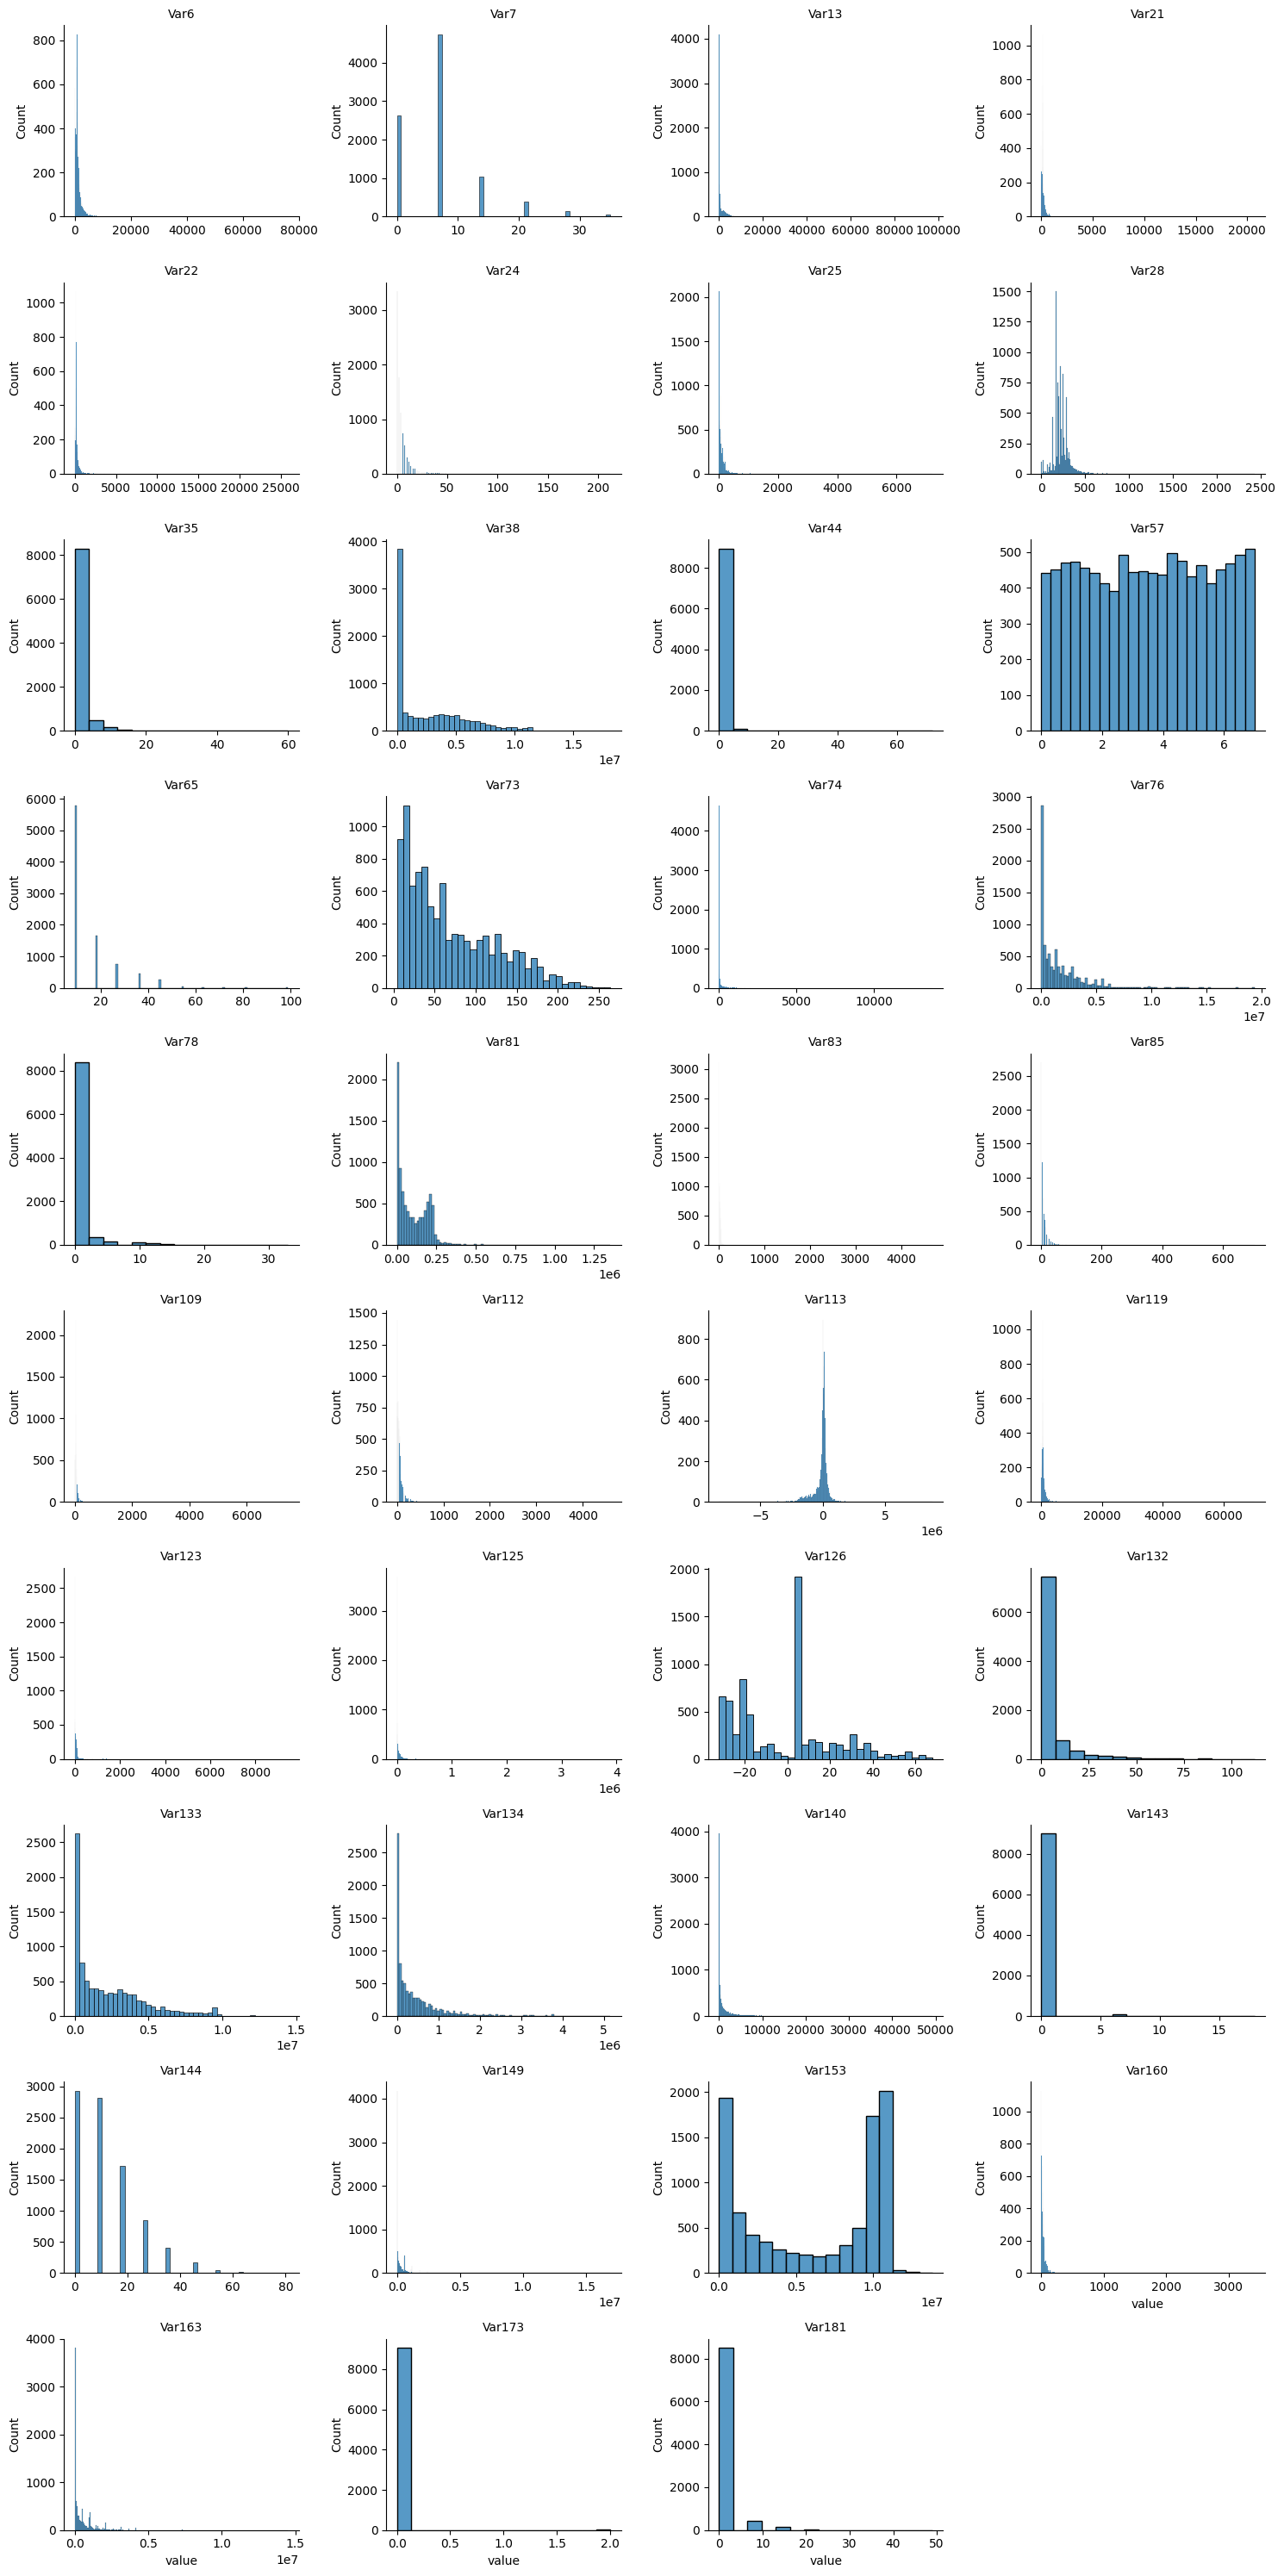

In [84]:
# Initial overview of the numerical data
X_num_descr = X_num.describe()
melted = X_num.melt()
g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=4,
                  sharex=False,
                  sharey=False,
                  aspect=1.25)
g.map(sns.histplot, 'value')
g.set_titles(col_template='{col_name}')
g.tight_layout()
plt.show()

#### Taking an inital Look at the Categorical Data Descriptor of Unique values

In [85]:
# Initial overview of the categorical data
X_cat_unique = X_cat.nunique()

print(X_cat_unique.sort_values(ascending=False))

Var217    5529
Var202    3802
Var222    2100
Var220    2100
Var198    2100
Var199    1850
Var216     977
Var192     297
Var197     185
Var204     100
Var212      65
Var193      40
Var228      29
Var226      23
Var206      21
Var195      18
Var219      17
Var207      12
Var221       7
Var227       7
Var210       6
Var203       4
Var223       4
Var205       3
Var196       3
Var208       2
Var211       2
Var218       2
dtype: int64


### Processing the Numerical Values

#### Processing the Outliers

Given that the dataset was quite large, and as seen from the distributions of numerical results below I notices that there were a lot of large and skewed distributions. As such I decided to remove the outliers from the data in correspondence to the proportion of columns that the features that the observations is found to be an outlier. I classified an observation being an outlier if it is 3 standard deviations from the mean in a given feature.

Upon using iterations in testing values, I also managed to find that the value of being an outlier in more than 5% of the features had the best impact on the classifying capacity of the model.

In [86]:
# Identify and exclude the outliers that are more that 3-sd above/below the mean

# =============================================================================
# Room to try different iterations of the nan_policy
# =============================================================================

df_zscore = zscore(X_num, nan_policy='omit')

X_num_out = np.abs(df_zscore).ge(3).astype(int).mean(1)

# =============================================================================
# Room to iterate with the level of cutoff of outliers
# =============================================================================

out_ind = np.where(X_num_out > 0.05)[0] # - Tested levels of 0.01, 0.05, 0.10, 0.20 and found that 0.05 is the minimum at least at a local level

X_num.drop(out_ind, inplace=True)

X_cat.drop(out_ind, inplace=True)

y_target.drop(out_ind, inplace=True)

#### Imputing and Scaling the numerical features

In [87]:
# Analyse, clean and fill in the numerical data
# Fill in the missing values
num_imputer = SimpleImputer().set_output(transform='pandas')
X_num = num_imputer.fit_transform(X_num)
# X_test_num = num_imputer.transform(X_test_num)
valid_num = num_imputer.transform(valid_num)


# Scaling all of the values
scaler = StandardScaler().set_output(transform='pandas')
X_num = scaler.fit_transform(X_num)
# X_test_num = scaler.transform(X_test_num)
valid_num = scaler.transform(valid_num)

Following the imputing and Scaling of the numerical features it became evident that the distributions started to look a lot better.

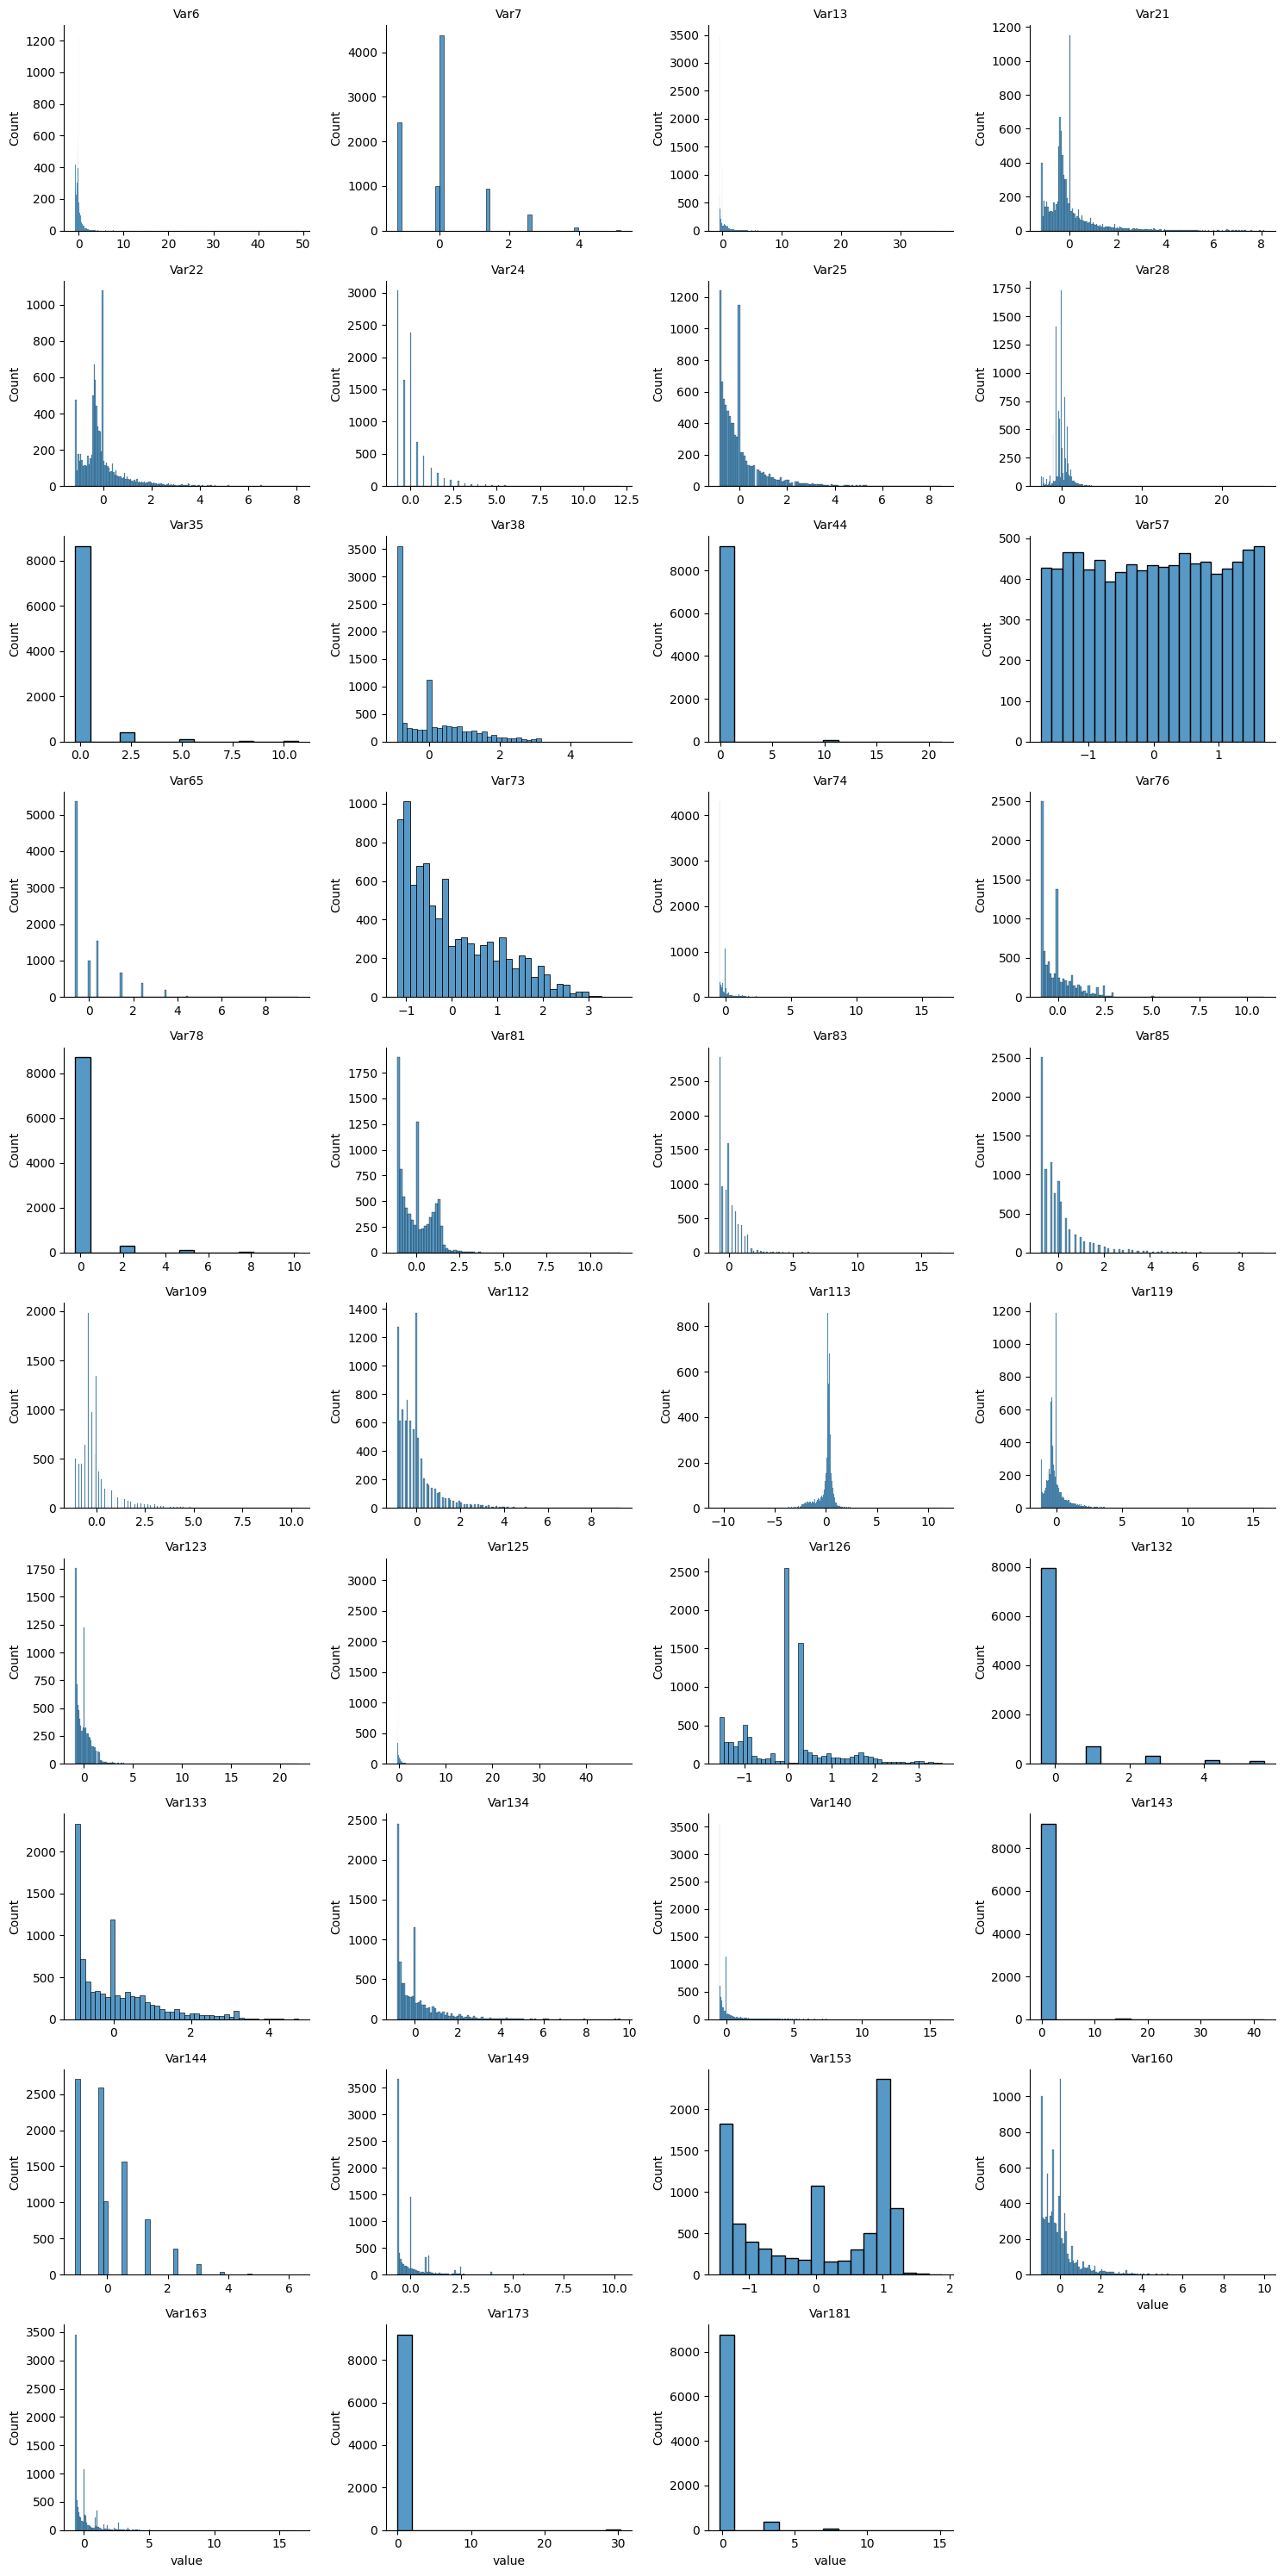

In [88]:
melted = X_num.melt()
g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=4,
                  sharex=False,
                  sharey=False,
                  aspect=1.25)
g.map(sns.histplot, 'value')
g.set_titles(col_template='{col_name}')
g.tight_layout()
plt.show()

#### Correlation Analysis

I then decided to look into a correlation analysis of the numerical features in order to remove the features that had a correlation of over 70% with another feature.

In doing so I believe that I was creating a way that removed the training model's overreliance on the highly correlated features and instead traind the classifier on the other features, which would reduce the chances of overtraining.

<Axes: >

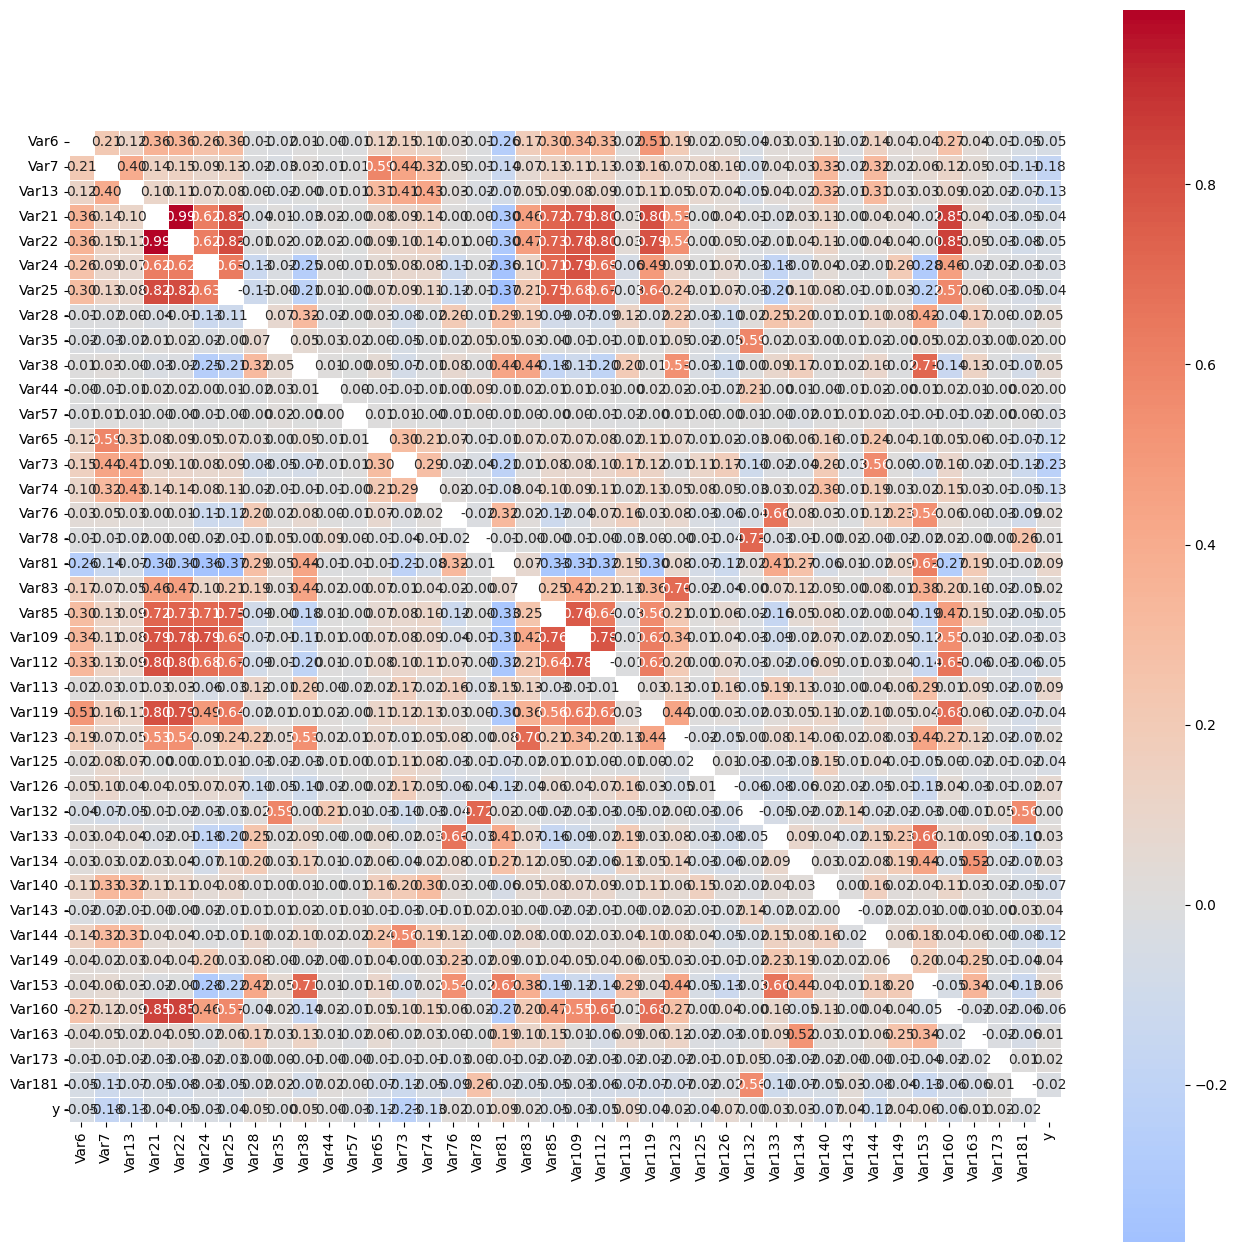

In [89]:
# Correlation analysis
num_subset = pd.concat([X_num, y_target], axis=1)
corr_mtx = num_subset.corr()

mask_mtx = np.zeros_like(corr_mtx)
np.fill_diagonal(mask_mtx, 1)

fig, ax = plt.subplots(figsize=(16, 16))

sns.heatmap(num_subset.corr(),
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f',
            linewidth=0.5,
            square=True,
            mask=mask_mtx,
            ax=ax)

Removing the features that had a correlation of over 70%

In [90]:
# =============================================================================
# Room to iterate with the exculded columns
# =============================================================================

# After looking at the correlation matrix I decided to further drop the columns that have high correlation (over 70%) with each other
corr_columns_to_drop = ['Var21','Var22','Var24','Var25','Var85', 'Var109', 'Var112', 'Var119','Var123', 'Var132', 'Var133', 'Var153']
X_num = X_num.drop(columns=corr_columns_to_drop)
# X_test_num = X_test_num.drop(columns=corr_columns_to_drop)
valid_num = valid_num.drop(columns=corr_columns_to_drop)

### Analysis of the Categorical Values

Within the Categorical Analysis I initally looked at excluding the Features that had a lot of cardinality. As the data is already hashed and depersonalised for the privacy of the dataset, there was little that could be done with the highly cardinal features that had a lot of unique values.

Following this I filled the remaining missing categorical values with the most frequently occurring value.

Following this I encoded the values to the target values using TargetEncoder as it allowed to differentiate the most valueable values of each feature based on how they impact the target variable.

Finally I adjusted the distribution of the categorical values using PowerTransformer.

In [91]:
# Analyse, clean and fill in the categorical data
pd.concat( [X_cat.nunique(), X_cat.apply(lambda x: x.unique()[:5])], axis=1)

# =============================================================================
# Room to iterate with the exculded cat columns
# =============================================================================

cat_columns_to_drop = ['Var198','Var199','Var202','Var216','Var217','Var220','Var222']
X_cat = X_cat.drop(columns=cat_columns_to_drop)
# X_test_cat = X_test_cat.drop(columns=cat_columns_to_drop)
valid_cat = valid_cat.drop(columns=cat_columns_to_drop)

cat_imputer = SimpleImputer(strategy='most_frequent').set_output(transform='pandas')
X_cat = cat_imputer.fit_transform(X_cat)
# X_test_cat = cat_imputer.transform(X_test_cat)
valid_cat = cat_imputer.transform(valid_cat)

# X_cat_unique = pd.concat( [X_cat.nunique(), X_cat.apply(lambda x: x.unique()[:5])], axis=1)

encoder = ce.TargetEncoder()
X_cat = encoder.fit_transform(X_cat, y_target)
# X_test_cat = encoder.transform(X_test_cat, y_test)
valid_cat = encoder.transform(valid_cat)

# =============================================================================
# Look into using a different approach to induce the PowerTransformer to the data
# =============================================================================

pt = PowerTransformer()
for col in X_cat.columns:
    X_cat[col] = pt.fit_transform(pd.DataFrame(X_cat[col]))
    # X_test_cat[col] = pt.transform(pd.DataFrame(X_test_cat[col]))
    valid_cat[col] = pt.transform(pd.DataFrame(valid_cat[col]))


### Combining the processed data back into a unified dataframe

In [92]:
# Combining the numerical and categorical values into one dataframe
X_df = pd.concat([X_num, X_cat], axis=1)
# X_df_test = pd.concat([X_test_num, X_test_cat], axis=1)
valid = pd.concat([valid_num, valid_cat], axis=1)

y_val_counts = y_target.value_counts(normalize=True)
# y_test_val_counts = y_test.value_counts(normalize=True)

### Oversampling the data using SMOTE

Follwong the processing of the data I decided to resample the dataset in order to balance the distribution of target values. I decided to use oversampling and the SMOTE method in order to increase the amount of true values in the target values as initially this amount was quite low.

Based on the understanding of the business case of the dataset this low amount of true target cases is understandable as the business wants to keep churned customers low. By using SMOTE oversampling the analysis is able to synthetically increase the amount of cases where there is true target values allowing the model to be able to generalize better.

In [93]:
# SMOTE code to equalise the target output so that all of the classes are of the same representation
# Mess around with the k_neighbours value to improve the model

lab_encoder = LabelEncoder()
encoded_y = lab_encoder.fit_transform(y_target)

# =============================================================================
# Room to iterate with the amount of neighbours
# =============================================================================

sm = SMOTE(random_state=42, k_neighbors=250)
X_df_res, y_target_res = sm.fit_resample(X_df, encoded_y)

## Building the Model

I built out the model over an iterative approach. I initially simply created the LogisticRegression in order to make sure that the classification works. With this predominantly linear approach to classification I got a result of around 60%.

Following testing the non-linear classifier models I noticed that the results were better, showing that the dataset most likely has underlying non-linear trends.

I then decided to try using ensamble methods of non-linear classifiers such as XGBoost and LightGBM. After trying these ensamble algorithms I saw that XGBoost had better performance based on how I prepared the dataframe.

The ultimate parameters that I found worked best were to have the number of estimators be at 100 as any higher value actually resulted in worse model perfromance. The optimal max-depth was around 4 and the optimal learning rate of 0.01. These values wer found by testing with the true dataset. However, had I been able to set up the conveyer model approach and when paired with cross-validation using training data, I probably could have tested the values further on my own machine and not have depended on the actual kaggle submissions and being limited to 10 daily submissions.

In [94]:
# Train a logistic regression model on the training data
# clf = (LogisticRegression(solver='liblinear',
#                           class_weight='balanced',
#                           random_state=42)
#         .fit(X_df_res, y_target_res))

In [95]:
# Train a GradientBoostingClassifier on the training data

# clf = (RandomForestClassifier()
#             .fit(X_df_res, y_target_res))

In [96]:
# Train a GradientBoostingClassifier on the training data

# clf = (GradientBoostingClassifier()
#             .fit(X_df_res, y_target_res))

In [97]:
clf = (XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.01, objective='binary:logistic')
       .fit(X_df_res, y_target_res))

In [98]:
# clf = (lgb.LGBMClassifier()
#        .fit(X_df_res, y_target_res))

## Creating the predictions and saving the results

In [99]:
# Test data predictions

# =============================================================================
# pred = clf.predict(X_df_test)
#
# ConfusionMatrixDisplay.from_predictions(y_test, pred)
#
# plt.show()
#
# pred_result_table = (classification_report(y_test, pred))
# =============================================================================


In [100]:
# Formatting output

output = pd.DataFrame({'index': valid.index,
                        'y': clf.predict(valid)})
output.to_csv('submission.csv', index=False)
